In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline 
plt.style.use('seaborn')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#new project

## Project outline
Goal of the project is to execute on the 4 tasks below
1. analyze shopper behaviors
2. create shopping cart recommendation system for return customers
3. predict whether customer would like to re-order item they bought before their next purchase
4. show different product recommendation using different user accs to sign in



## Dataset Background
Instacart public dataset released in 2017 (https://www.instacart.com/datasets/grocery-shopping-2017)
In Instacart medium post, they provided more info about the dataset and motivation on why Instacart released the dataset (https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).

The dataset has more than 3M grocery orders for more than 200k Instacart customers.

Data Dictionary could be found at https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b.
The data file comes with 6 csv files.

In [2]:
#Load all CSVs 
#creating variable names as a short way to refer to each of the cell tabs
#make sure the .csv files are in the same folder as the jupyter notebook- do not store the .csv in another folder otherwise will trigger permission error
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [3]:
#looking at our data
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
aisles.shape
#we know theres 134 aisles

(134, 2)

In [5]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
departments.shape
#there are 21 unique departments

(21, 2)

In [8]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_products_prior.shape

(32434489, 4)

In [10]:
len(order_products_prior.order_id.unique())

3214874

In [11]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
order_products_train.shape

(1384617, 4)

In [13]:
len(order_products_train.order_id.unique())

131209

In [14]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [15]:
orders.shape

(3421083, 7)

# products

In [16]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [17]:
products.shape

(49688, 4)

# explore more on orders

In [18]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [19]:
print(orders.shape)
print('there are', len(orders[orders.eval_set == 'prior']), 'entries for prior')
print('there are', len(orders[orders.eval_set == 'train']), 'entries for train')
print('there are', len(orders[orders.eval_set == 'test']), 'entries for test')

(3421083, 7)
there are 3214874 entries for prior
there are 131209 entries for train
there are 75000 entries for test


In [20]:
print('there are', len(orders[orders.eval_set == 'prior'].user_id.unique()), 'unique customers in total')
print('there are', len(orders[orders.eval_set == 'train'].user_id.unique()), 'unique customers in train set')
print('there are', len(orders[orders.eval_set == 'test'].user_id.unique()), 'unique customers in test set')

there are 206209 unique customers in total
there are 131209 unique customers in train set
there are 75000 unique customers in test set


# plot the distribution of orders
#want to answer the question: how many customers ordered 4 times? how many customers ordered 5 times? etc.

In [21]:
orders_amount_for_customer = orders.groupby('user_id')['order_number'].count().value_counts()
#value_counts counts the # of rows with each unique value of variable
#count counts the non-NA/null values of each object
#so combining the two will give you:info like 23986 customers ordered 4 times, 19590 customers ordered 5 times..etc etc
orders_amount_for_customer.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

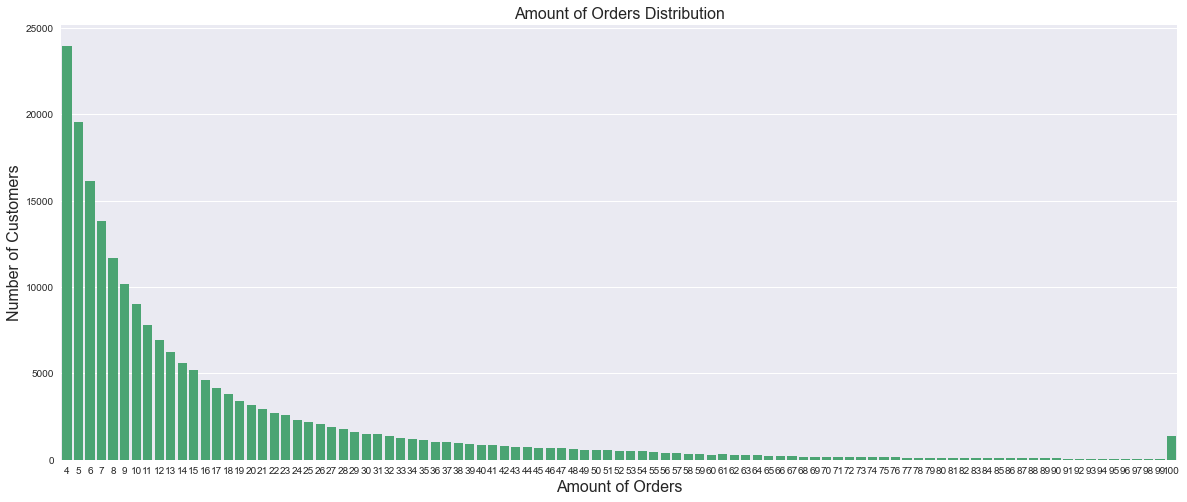

In [22]:
orders_amount_for_customer = orders.groupby('user_id')['order_number'].count().value_counts()

plt.figure(figsize=(20,8))
sns.barplot(x=orders_amount_for_customer.index, y=orders_amount_for_customer.values, color='mediumseagreen')
#sns.barplot(x=....... , y=......... , color='red')
#use barplot when you have 2 diff variables to plot, not just counting the occurences of a variable
#use countplot if you're just counting the occurrences of a variable
plt.title('Amount of Orders Distribution', fontsize=16)
plt.ylabel('Number of Customers', fontsize=16)
plt.xlabel('Amount of Orders', fontsize=16)
plt.xticks(rotation='horizontal');

long tail problem


In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [24]:
#convert order_dow into days

days = orders.order_dow.values.tolist()
def get_day():
    res = []
    for day in days:
        if day ==0:
            res.append('Sun')
        elif day ==1:
            res.append('Mon')
        elif day ==2:
            res.append('Tue')
        elif day ==3:
            res.append('Wed')
        elif day ==4:
            res.append('Thur')
        elif day ==5:
            res.append('Fri')
        elif day ==6:
            res.append('Sat')
    return res

In [25]:
z = orders.copy()
#make a copy of the orders table, which we will add the day of week column to

In [26]:
z['order_dayofweek']=get_day()
#assigning a day of week to each number, 0= sunday,1=monday, etc
#this will add a 'order_dayofweek column to the table'

In [27]:
z.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_dayofweek
0,2539329,1,prior,1,2,8,NaN,Tue
1,2398795,1,prior,2,3,7,15.0,Wed
2,473747,1,prior,3,3,12,21.0,Wed
3,2254736,1,prior,4,4,7,29.0,Thur
4,431534,1,prior,5,4,15,28.0,Thur


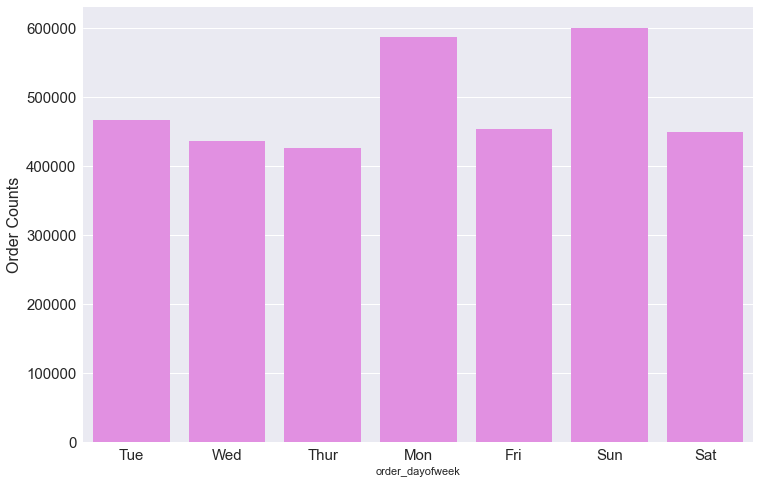

In [28]:
plt.figure(figsize=(12,8))
sns.countplot(x=z.order_dayofweek, color='violet')
#count the number of orders in each day of the week

plt.xticks(fontsize=15)
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15);

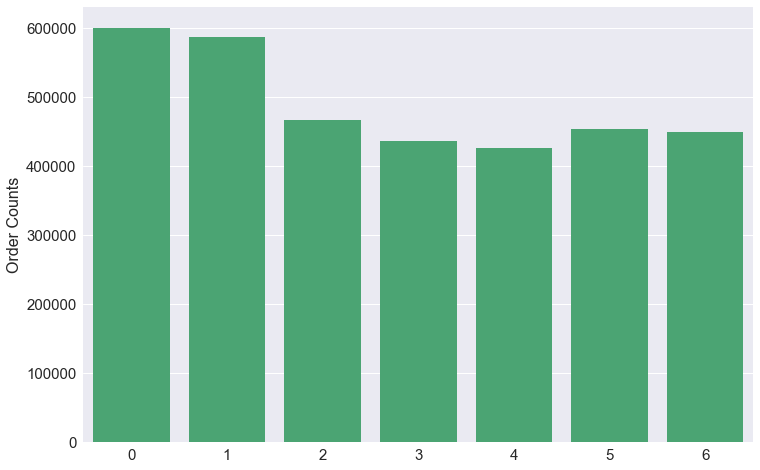

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x=orders.order_dow, color='mediumseagreen')

#plt.title("Order Amounts by Days", fontsize=16)
plt.xlabel('', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Order Counts',fontsize=16)
plt.yticks(fontsize=15);


In [30]:
#0 and 1 (sunday & monday) have the most orders in a week, on thursday its the least amt of orders

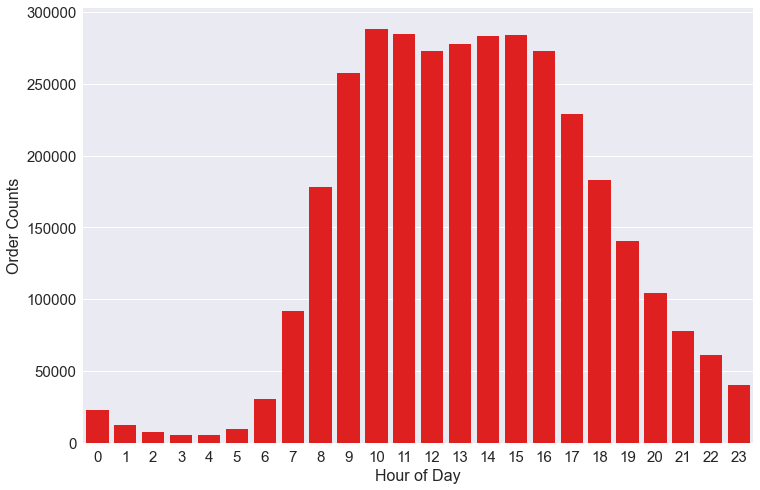

In [31]:
#Now lets analyze time of day

#plot the size of the figure
plt.figure(figsize=(12,8))
#create the countplot (only need to specify x dimension and color)
sns.countplot(x=orders.order_hour_of_day, color='red')

plt.xlabel('Hour of Day', fontsize=16)
plt.xticks(fontsize=15)
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15);

In [32]:
#people tend to order from 8am to 6pm (8-18)

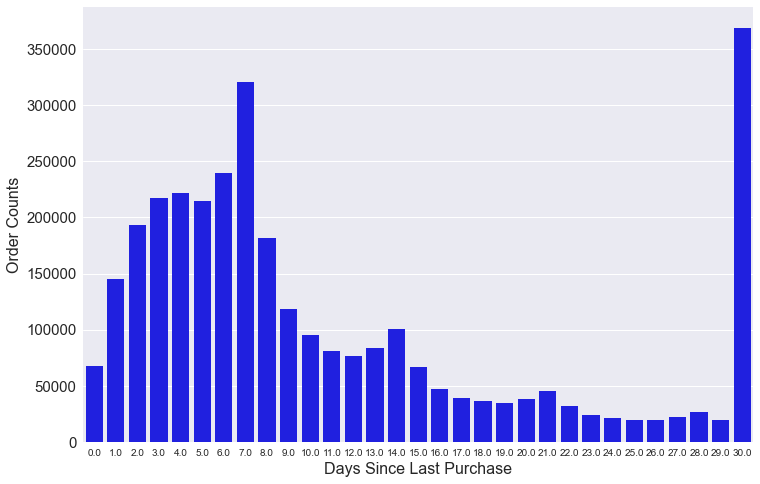

In [33]:
#count the num of days since last order

#set the dimensions
plt.figure(figsize=(12,8))
#create the countplot 
sns.countplot(x=orders.days_since_prior_order, color='blue')
#put in the labels 

plt.xlabel('Days Since Last Purchase', fontsize=16)
plt.xticks(fontsize=10)
plt.ylabel('Order Counts', fontsize=16)
plt.yticks(fontsize=15);


In [34]:
#Majority of people order once a week, btwn 0-7
#lots of people who order once more than 30 days ago (buying a one-time thing)

# Exploring on order_product_prior and order product train

In [35]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [36]:
#order in which an item was added to basket, 1 means it was the first item added, positioning of order

In [37]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [38]:
print(order_products_prior.shape)
print(order_products_train.shape)
#this gives the dimensions for each table- how many columns and rows

(32434489, 4)
(1384617, 4)


In [39]:
order_products_total=pd.concat([order_products_prior, order_products_train])
#combining the prior and train tables together into one table, stacking them on top of each other horizontally
#(prior on top, train on bottom)

print(order_products_total.shape)

(33819106, 4)


In [40]:
order_products_total.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


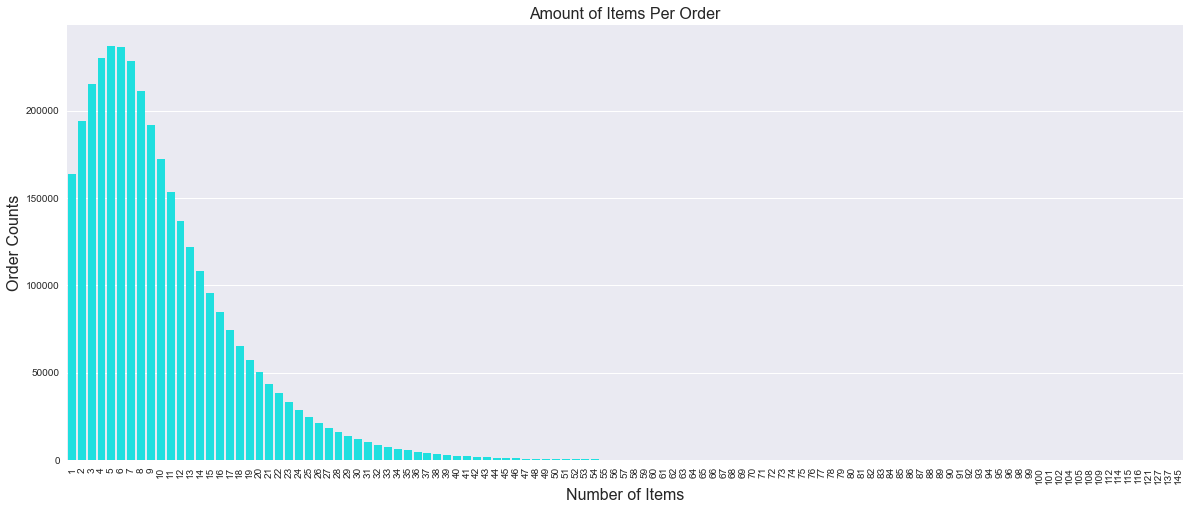

In [41]:
frequency_per_number_of_order = order_products_total.groupby('order_id')['product_id'].count().value_counts()

plt.figure(figsize=(20,8))
sns.barplot(x=frequency_per_number_of_order.index, y=frequency_per_number_of_order.values, color='cyan')
plt.title('Amount of Items Per Order', fontsize=16)
plt.ylabel('Order Counts', fontsize=16)
plt.xlabel('Number of Items', fontsize=16)
plt.xticks(rotation='vertical');

In [42]:
#majority of people purchase 1-10 items per order
#can normalize using log, will normalize the distribution
#left skew and right skew charts cannot utilize the statistical tools a normal distribution can

In [43]:
print('there are', order_products_total.shape[0], 'grocery products ordered')
print('there are', len(order_products_total.order_id.unique()), 'order transactions')
print('there are', len(order_products_total.product_id.unique()), 'unique products')

there are 33819106 grocery products ordered
there are 3346083 order transactions
there are 49685 unique products


In [44]:
print(len(order_products_total[order_products_total.reordered == 1])/order_products_total.shape[0], 'have reordered before')
print(len(order_products_total[order_products_total.reordered == 0])/order_products_total.shape[0], 'haven\'t reordered before')


0.5900617242809434 have reordered before
0.40993827571905656 haven't reordered before


In [45]:
#the split between people who have reordered and haven't is 60-40

# exploring the aisle, department & products files

In [46]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [47]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [48]:

products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [49]:
#grabbing the dimensions
print(aisles.shape)
print(departments.shape)
print(products.shape)

(134, 2)
(21, 2)
(49688, 4)


In [50]:
#do a merge to combine department and 
products_departments = products.merge(departments, left_on='department_id', right_on='department_id', how='left')
products_departments_aisles = products_departments.merge(aisles, left_on= 'aisle_id',right_on='aisle_id',how='left')
products_departments.head(15)
#products_departments_aisles.head(15)

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry
5,6,Dry Nose Oil,11,11,personal care
6,7,Pure Coconut Water With Orange,98,7,beverages
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen
8,9,Light Strawberry Blueberry Yogurt,120,16,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,beverages


In [51]:
products_departments_aisles.head(15)

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation
5,6,Dry Nose Oil,11,11,personal care,cold flu allergy
6,7,Pure Coconut Water With Orange,98,7,beverages,juice nectars
7,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen,frozen produce
8,9,Light Strawberry Blueberry Yogurt,120,16,dairy eggs,yogurt
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,beverages,water seltzer sparkling water


In [52]:
products_departments_aisles.groupby('department')['product_id'].count().reset_index().sort_values(by='product_id', ascending=False).head(10)

,department,product_id
17,personal care,6563
20,snacks,6264
16,pantry,5371
3,beverages,4365
10,frozen,4007
7,dairy eggs,3449
11,household,3085
6,canned goods,2092
9,dry goods pasta,1858
19,produce,1684


In [53]:
#Explore more on products_departments_aisles & order_products_total

In [54]:
order_products_total.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [55]:
products_departments_aisles.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [56]:
df = order_products_total.merge(products_departments_aisles, left_on='product_id', right_on='product_id', how='left')
df.head(100)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients
...,...,...,...,...,...,...,...,...,...
95,11,1313,4,1,Tortilla Strips Restaurant Style,107,19,snacks,chips pretzels
96,11,31506,5,1,Extra Virgin Olive Oil,19,13,pantry,oils vinegars
97,12,30597,1,1,French Vanilla Coffee Creamer,53,16,dairy eggs,cream
98,12,15221,2,1,2% Milk,84,16,dairy eggs,milk


In [57]:
df.shape

(33819106, 9)

In [58]:
top_15_products = df.product_name.value_counts(ascending=False).reset_index().head(10)
top_15_products.columns=['product_name','count']
top_15_products

,product_name,count
0,Banana,491291
1,Bag of Organic Bananas,394930
2,Organic Strawberries,275577
3,Organic Baby Spinach,251705
4,Organic Hass Avocado,220877
5,Organic Avocado,184224
6,Large Lemon,160792
7,Strawberries,149445
8,Limes,146660
9,Organic Whole Milk,142813


In [59]:
df.groupby('department')

In [60]:
reorder_ratio_per_dep = df.groupby('department')['reordered'].mean().reset_index()
reorder_ratio_per_dep.columns = ['department', 'reorder_ratio']
reorder_ratio_per_dep.sort_values(by='reorder_ratio',ascending=False)

,department,reorder_ratio
7,dairy eggs,0.670161
3,beverages,0.653651
19,produce,0.650521
2,bakery,0.628381
8,deli,0.608130
18,pets,0.602557
1,babies,0.577680
5,bulk,0.577090
20,snacks,0.574464
0,alcohol,0.571221


In [61]:
#how to interprep the reorder ratio- 67% of the items ordered under the 'dairy eggs' department had been reordered before, ie reordered=1

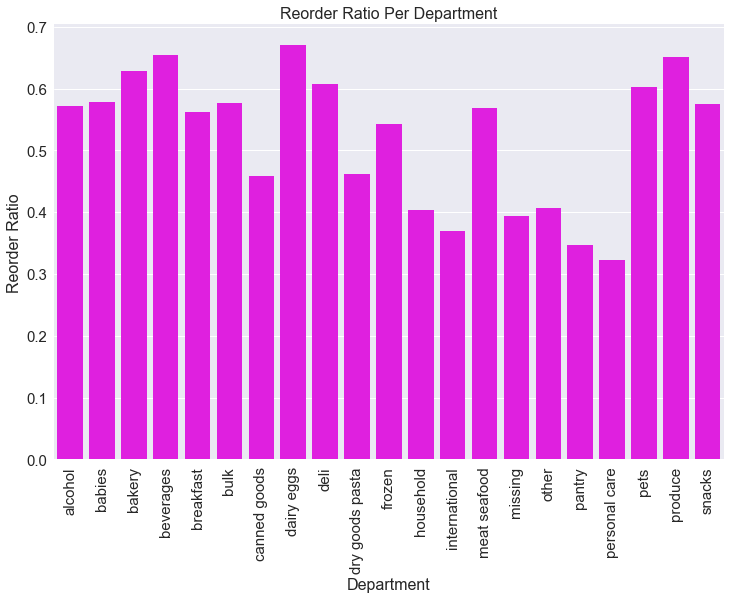

In [62]:
plt.figure(figsize=(12,8))
sns.barplot(x=reorder_ratio_per_dep.department, y=reorder_ratio_per_dep.reorder_ratio, color='magenta')
plt.title('Reorder Ratio Per Department', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel('Reorder Ratio', fontsize=16)
plt.yticks(fontsize=15);

In [63]:
#dairy eggs has highest reorder ratio
#personal care has the least reorder ratio

In [64]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [65]:
reorder_ratio_per_aisle = df.groupby('aisle')['reordered'].mean().reset_index()
reorder_ratio_per_aisle.columns = ['aisle', 'reorder_ratio']
reorder_ratio_per_aisle.sort_values(by='reorder_ratio',ascending=False)

,aisle,reorder_ratio
83,milk,0.781812
131,water seltzer sparkling water,0.729930
50,fresh fruits,0.718823
41,eggs,0.706359
119,soy lactosefree,0.692361
...,...,...
8,beauty,0.212858
47,first aid,0.195864
76,kitchen supplies,0.194802
7,baking supplies decor,0.167595


In [66]:
#milk has the highest reorder ratio
#spices has the least reorder ratio

In [67]:
top_15_reorder_items = df.groupby('product_name')['reordered'].sum().reset_index().sort_values(by='reordered', ascending = False).head(15)
top_15_reorder_items

,product_name,reordered
3677,Banana,415166
3472,Bag of Organic Bananas,329275
31923,Organic Strawberries,214448
28843,Organic Baby Spinach,194939
30300,Organic Hass Avocado,176173
28807,Organic Avocado,140270
32481,Organic Whole Milk,118684
22415,Large Lemon,112178
31366,Organic Raspberries,109688
42908,Strawberries,104588


In [68]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [69]:
add_to_cart_order_reordered_ratio = df.groupby('add_to_cart_order')['reordered'].mean().reset_index()
add_to_cart_order_reordered_ratio.head()

,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


C:\Users\joshs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


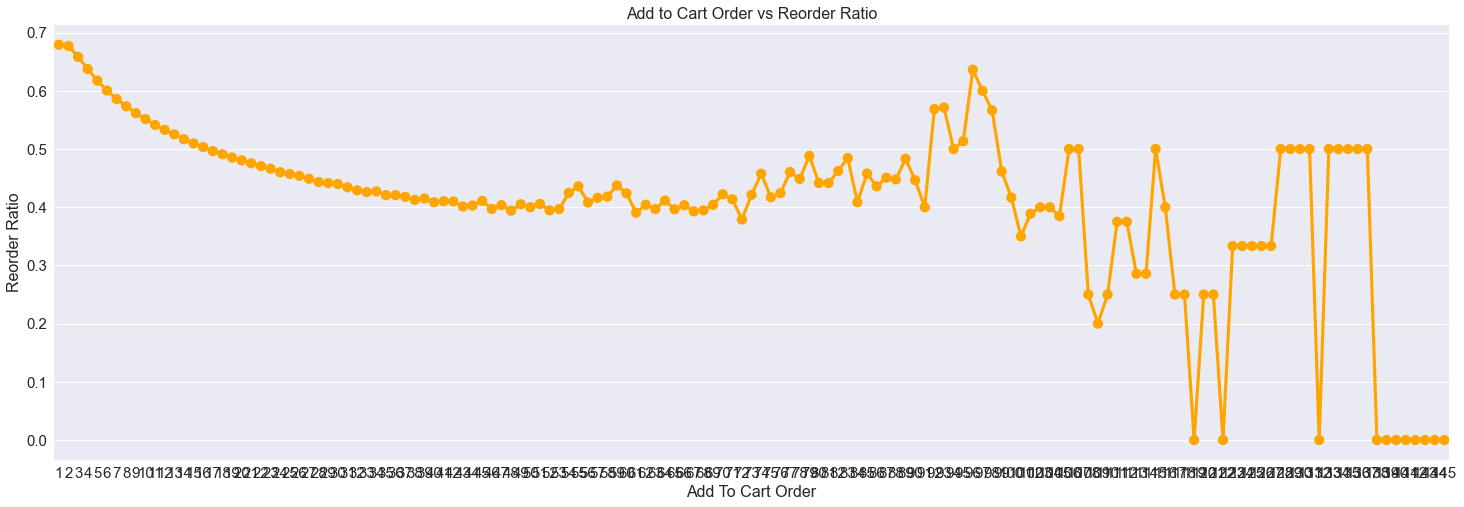

In [70]:
plt.figure(figsize=(25,8))
sns.pointplot(add_to_cart_order_reordered_ratio.add_to_cart_order, add_to_cart_order_reordered_ratio.reordered, color='orange')
plt.title('Add to Cart Order vs Reorder Ratio', fontsize=16)
plt.xlabel('Add To Cart Order', fontsize=16)
plt.xticks(fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel('Reorder Ratio', fontsize=16)
plt.yticks(fontsize=15);

#how to fix the tickers here


# looking at what items ordered before noon, what items ordered after noon

In [71]:
# remove any rows referring to the test set
df_orders = orders[orders.eval_set != 'test']

# drop the eval_set column
df_orders = df_orders.drop(['eval_set'], axis=1)

# concatenate the _prior and _train datasets
df_order_products = pd.concat([order_products_prior, order_products_train])

# expand every order_id with the list of product_ids in that order_id
temp = df_orders.merge(df_order_products, on='order_id')
temp.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,1,2,8,NaN,196,1,0
1,2539329,1,1,2,8,NaN,14084,2,0
2,2539329,1,1,2,8,NaN,12427,3,0
3,2539329,1,1,2,8,NaN,26088,4,0
4,2539329,1,1,2,8,NaN,26405,5,0


In [72]:
##keep only top 2000 products
top_products = pd.DataFrame({'total_count': temp.groupby('product_id').size()}).sort_values('total_count', ascending=False).reset_index()[:2000]
top_products = top_products.merge(products,on='product_id')
top_products = top_products.merge(products, on='product_id')
top_products.head()

,product_id,total_count,product_name_x,aisle_id_x,department_id_x,product_name_y,aisle_id_y,department_id_y
0,24852,491291,Banana,24,4,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4,Organic Hass Avocado,24,4


In [73]:
#keep only observations that have products in top_products
temp = temp.loc[temp['product_id'].isin(top_products.product_id)]

In [74]:
product_orders_by_hour = pd.DataFrame({'count': temp.groupby(['product_id', 'order_hour_of_day']).size()}).reset_index()
product_orders_by_hour['pct'] = product_orders_by_hour.groupby('product_id')['count'].apply(lambda x: x/x.sum()*100)
product_orders_by_hour.head(24)

,product_id,order_hour_of_day,count,pct
0,34,0,23,0.339283
1,34,1,18,0.265526
2,34,2,11,0.162266
3,34,3,5,0.073757
4,34,4,5,0.073757
5,34,5,15,0.221272
6,34,6,57,0.840832
7,34,7,202,2.979791
8,34,8,402,5.930078
9,34,9,509,7.508482


In [75]:
mean_hour = pd.DataFrame({'mean_hour': product_orders_by_hour.groupby('product_id').apply(lambda x: sum(x['order_hour_of_day'] * x['count'])/sum(x['count']))}).reset_index()
mean_hour.head()

,product_id,mean_hour
0,34,13.511285
1,45,13.398624
2,79,13.502530
3,116,12.516822
4,117,13.392173


In [76]:
morning = mean_hour.sort_values('mean_hour')[:25]
morning = morning.merge(products, on='product_id')
morning.head()

,product_id,mean_hour,product_name,aisle_id,department_id
0,9292,11.767279,Half And Half Ultra Pasteurized,84,16
1,46562,11.898340,Sweet & Salty Nut Granola Bars Peanut,3,19
2,45051,12.004019,Pub Mix,107,19
3,36472,12.049459,Nutri Grain Bars Multi Pack,48,14
4,37710,12.059043,Trail Mix,125,19


In [77]:
afternoon = mean_hour.sort_values('mean_hour', ascending=False)[:25]
afternoon = afternoon.merge(products, on='product_id')
afternoon.head()

,product_id,mean_hour,product_name,aisle_id,department_id
0,30668,14.526986,Half Baked Frozen Yogurt,37,1
1,45541,14.526299,The Tonight Dough™ Ice Cream,37,1
2,45681,14.394912,Americone Dream® Ice Cream,37,1
3,46175,14.388942,Half Baked® Ice Cream,37,1
4,14335,14.373308,Phish Food® Ice Cream,37,1


In [78]:
morning_pct = product_orders_by_hour.merge(morning, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'])
afternoon_pct = product_orders_by_hour.merge(afternoon, on='product_id').sort_values(['mean_hour', 'order_hour_of_day'], ascending=False)

In [79]:
# get list of morning and afteroon product names
morning_product_names = list(morning_pct['product_name'].unique())
morning_product_names = '\n'.join(morning_product_names)
afternoon_product_names = list(afternoon_pct['product_name'].unique())
afternoon_product_names = '\n'.join(afternoon_product_names)

# hack to remove 'Variety Pack' from Orange & Lemon Flavor Variety Pack Sparkling Fruit Beverage
morning_product_names = morning_product_names.replace('Variety Pack ', '')

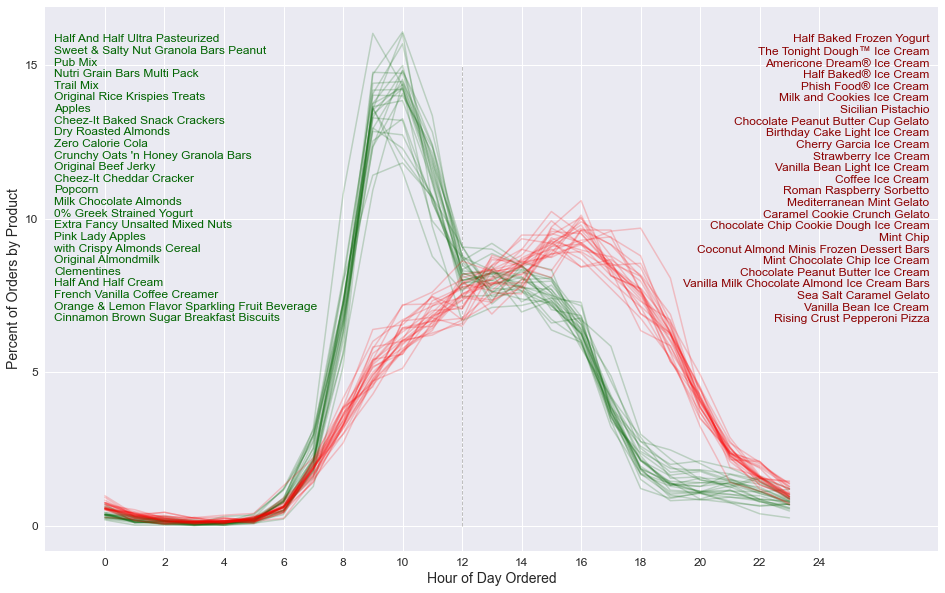

In [80]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 10))

# Plot
morning_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                       y='pct', 
                                       ax=ax, 
                                       legend=False,
                                       alpha=0.2,
                                       aa=True,
                                       color='darkgreen',
                                       linewidth=1.5,)
afternoon_pct.groupby('product_id').plot(x='order_hour_of_day', 
                                         y='pct', 
                                         ax=ax, 
                                         legend=False,
                                         alpha=0.2,
                                         aa=True,
                                         color='red',
                                         linewidth=1.5,)

# Aesthetics
# Margins
plt.margins(x=0.5, y=0.05)

# Hide spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Labels
label_font_size = 14
plt.xlabel('Hour of Day Ordered', fontsize=label_font_size)
plt.ylabel('Percent of Orders by Product', fontsize=label_font_size)

# Tick Range
tick_font_size = 12
ax.tick_params(labelsize=tick_font_size)
plt.xticks(range(0, 25, 2))
plt.yticks(range(0, 16, 5))
plt.xlim([-2, 28])

# Vertical line at noon
plt.vlines(x=12, ymin=0, ymax=15, alpha=0.5, color='gray', linestyle='dashed', linewidth=1.0)

# Text
text_font_size = 12
ax.text(0.01, 0.95, morning_product_names,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='darkgreen', fontsize=text_font_size)
ax.text(0.99, 0.95, afternoon_product_names,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='darkred', fontsize=text_font_size);

In [81]:
#need to do statistical analysis
#do people constantly buy the same things, or are people looking to buy new things

#is it worth building a recommendation system? if people already know what they want to buy, what percentage of people constantly buy the same things
#how many items were new?

#if a large portion of people are buying the same thing, want to build recommendation system showing them similar items
#upsell or cross sell (buying a lot of video games --> recommend a gaming chair)
#the way we can build similarity now is to see who bought what
#items under the same aisle/department
#what are the questions you need to answer before building the model


#what crowd to do you want to cater to? People that reordered

#use stat work done for london housing project
#based on the outcome we wanted to solve, what were the statistical tests needed?

London calling was about finding the borough of london with the largest housing price increases, which we obtained by calculating which
graph had the largest linear coefficient



# post project analysis

In [82]:
#finding top 15 aisles

top_15_aisles = df.aisle.value_counts(ascending=False).reset_index().head(15)
top_15_aisles.columns=['aisle_name','count']
top_15_aisles

,aisle_name,count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
5,milk,923659
6,water seltzer sparkling water,878150
7,chips pretzels,753739
8,soy lactosefree,664493
9,bread,608469


In [83]:
#define the variable, use value_counts
top_15_department=df.department.value_counts(ascending=False).reset_index().head(15)

top_15_department.columns= ['department_name','count']
top_15_department

#reset index


,department_name,count
0,produce,9888378
1,dairy eggs,5631067
2,snacks,3006412
3,beverages,2804175
4,frozen,2336858
5,pantry,1956819
6,bakery,1225181
7,canned goods,1114857
8,deli,1095540
9,dry goods pasta,905340


In [84]:
top_15_department=df.department.value_counts.head(10)

AttributeError: 'function' object has no attribute 'head'

In [ ]:
#findout reorder ratio per department
# this is ONE entire line
reorder_ratio_per_dep = df.groupby('department')['reordered'].mean().reset_index()
reorder_ratio_per_dep.columns = ['department', 'reorder_ratio']
reorder_ratio_per_dep.sort_values(by='reorder_ratio',ascending=False)

In [ ]:
#dairy eggs most reorder ratio
#personal care has least reorder ratio

In [ ]:
#find out reorder ratio peer aisle.

reorder_ratio_per_aisle = df.groupby('aisle')['reordered'].mean().reset_index()
reorder_ratio_per_aisle.columns = ['aisle','reorder_ratio']
reorder_ratio_per_aisle.sort_values(by='reorder_ratio',ascending=False)


In [ ]:
#milk has the highest reorder ratio for aisle
#spice seasoning has the lowest reorder ratio for aisle

In [ ]:
# get the list of orders that have been reordered before
reorders = order_products_total[order_products_total['reordered'] == 1]
orders2 = orders[['order_id', 'user_id']]
# merge to get user_id and product_id
user_orders = reorders.merge(orders2, on='order_id')
# filtering out the high volumn products that user reordered more than once
user_orders['high_volume'] = (user_orders['product_id'].value_counts().sort_values(ascending=False)>1)
high_volume = user_orders[user_orders['high_volume'] == True]
# get a matrix of different high volume items that particular user purchased
high_volume_users = high_volume.groupby(['user_id', 'product_name']).size().sort_values(ascending=False).unstack().fillna(0)
# calculate similarity between each user
cosine_dists = pd.DataFrame(cosine_similarity(high_volume_users),index=high_volume_users.index, columns=high_volume_users.index)
cosine_dists.head()

In [ ]:
def Recommender_System(user_id):
    
    '''
    enter user_id and return a list of 5 recommendations.
    '''
    
    u = high_volume.groupby(['user_id','product_name']).size().sort_values(ascending=False).unstack().fillna(0)
    u_sim = pd.DataFrame(cosine_similarity(u), index=u.index, columns=u.index)

    p = high_volume.groupby(['product_name','user_id']).size().sort_values(ascending=False).unstack().fillna(0)
    
    recommendations = pd.Series(np.dot(p.values,cosine_dists[user_id]), index=p.index)
    return recommendations.sort_values(ascending=False).head()
# recommendation for custome

In [ ]:
#Understanding the 